In [3]:
import tensorflow as tf
import keras
from tensorflow.keras import datasets, models, layers, Input

from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add, Dropout, LeakyReLU
from keras.models import Sequential
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras.utils import load_img, img_to_array

import os
import av
import shutil
import imghdr
import random
from PIL import Image
import pickle
import numpy as np
import math

from scipy.special import softmax
import matplotlib.pyplot as plt

In [6]:
print(tf.config.get_visible_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [10]:
DS_CDFV1 = 'celeb_df_v1/'
DS_CDFV2 = 'celeb_df_v2/'

DS_ORGINAL = 'dataset_original/'
DS_SPLIT = 'dataset_split/'
DS_IFRAMES = 'dataset_iframes/'
DS_FACE = 'dataset_face/'
DS_FACE_IMG = 'dataset_face_img/'
DS_SRM_SNIPPETS = 'dataset_srm_snippets_5/'
DS_SEGMENTS = 'dataset_segments/'
DS_RAW = 'dataset_raw/'
DS_RESIDUALS = 'dataset_residuals/'
DS_TEMPORAL = 'dataset_temporal/'

DS_FRAME_DIFF = 'dataset_frame_diff/'
DS_FRAME_DIFF_IMG = 'dataset_frame_diff_img/'

DS_SEG_COUNT_1 = '1_segment/'
DS_SEG_COUNT_2 = '2_segments/'
DS_SEG_COUNT_3 = '3_segments/'
DS_SEG_COUNT_4 = '4_segments/'
DS_SEG_COUNT_5 = '5_segments/'

SEG_COUNT = [DS_SEG_COUNT_1, DS_SEG_COUNT_2, DS_SEG_COUNT_3, DS_SEG_COUNT_4, DS_SEG_COUNT_5]

SEG_1 = 'seg_1/'
SEG_2 = 'seg_2/'
SEG_3 = 'seg_3/'
SEG_4 = 'seg_4/'
SEG_5 = 'seg_5/'

SEG = ['seg_1_', 'seg_2_', 'seg_3_', 'seg_4_', 'seg_5_']

DS_TRAIN = 'train_dataset/'
DS_TEST = 'test_dataset/'
DS_VAL = 'val_dataset/'

CLASS_FAKE = 'fake/'
CLASS_REAL = 'real/'


TOP_LEVEL_1 = [DS_SPLIT, DS_IFRAMES, DS_FACE, DS_FACE_IMG, DS_SRM_SNIPPETS]
TOP_LEVEL_2 = [DS_SEGMENTS, DS_RAW, DS_RESIDUALS]
SEGMENTS = [SEG_1, SEG_2, SEG_3, SEG_4, SEG_5]
SPLIT = [DS_TRAIN, DS_TEST, DS_VAL]
CLASS = [CLASS_REAL, CLASS_FAKE]

DATASET = [DS_CDFV1, DS_CDFV2]

In [9]:
SAVE_CHECKPOINT_PATH = 'models/TEMPORAL_MODEL/checkpoints/'
SAVE_METRICS_PATH = 'models/TEMPORAL_MODEL/metrics/'
SAVE_MODEL_PATH = 'models/TEMPORAL_MODEL/final_model/'
BACKUP_MODEL_PATH = 'models/TEMPORAL_MODEL/backups/'

TEST_SCORE_PATH = 'test_scores/'

# Frame Extraction

In [4]:
# Returns the index of frames that begin a new segment (except the first segment)
def get_segment_dividers(frame_count, num_segments):
    segments_per_frame = math.floor(frame_count / num_segments)

    return [(segments_per_frame * i) for i in range(1, num_segments) ]

In [5]:
# Returns the indices of the frames that will be randomly selected from each segment
# Multiple snippets indices per segment can be returned by setting the num_snippets arg 
def get_snippet_indices(segment_dividers, num_snippets):
    start_index = 0
    num_snippets = 1 if num_snippets <= 0 else num_snippets

    snippet_indices = []
    for end_index in segment_dividers:

        # Extracting multiple snippets per segment (if needed)
        for _ in range(num_snippets):
            snippet_indices.append(random.randint(start_index, end_index - 1))

        start_index = end_index
        
    return snippet_indices

In [6]:
# Returns an array of randomly selected snippets(PIL.Image) from each segment of the input video
def extract_snippets(fp, num_segments, num_snippets):
    vid_container = av.open(fp)
    vid_stream = vid_container.streams.video[0]
    frame_count = vid_stream.frames

    snippets = []

    # If number of frames in video is less than the number of frames that need to sampled
    # then take all frames in the video
    if frame_count < num_segments * num_snippets:
        for frame in vid_container.decode():
            snippets.append(frame.to_image())

    else:
        segment_dividers = get_segment_dividers(frame_count, num_segments)
        segment_dividers = segment_dividers + [frame_count]

        snippet_indices = get_snippet_indices(segment_dividers, num_snippets)

        frame_index = 0
        for frame in vid_container.decode():
            if frame_index > max(snippet_indices):
                break

            if frame_index in snippet_indices:
                snippets.append(frame.to_image())

            frame_index += 1

    return snippets

In [7]:
def extract_frames_from_video(fp):
    vid_container = av.open(fp)

    frames = []
    for frame in vid_container.decode():
        frames.append(frame.to_image())

    return frames

In [8]:
def create_image_dataset(dataset):
    assert dataset == DS_CDFV1 or dataset == DS_CDFV2

    src_base_path = dataset + DS_FRAME_DIFF
    dst_base_path = dataset + DS_FRAME_DIFF_IMG

    for split in SPLIT:
        print(f'---Split started: {split}---')

        for class_dir in CLASS:
            print(f'Class started: {class_dir}')

            for video in os.listdir(src_base_path + split + class_dir):
                fp = src_base_path + split + class_dir + video
                frames = extract_frames_from_video(fp)

                for i, frame in enumerate(frames, start=1):
                    frame = frame.resize((224, 224))
                    dst = f'{dst_base_path + split + class_dir + os.path.splitext(video)[0]}_f{i}.jpeg'
                    frame.save(dst)

In [66]:
create_image_dataset(DS_CDFV2)

---Split started: train_dataset/---
Class started: real/
Class started: fake/
---Split started: test_dataset/---
Class started: real/
Class started: fake/
---Split started: val_dataset/---
Class started: real/
Class started: fake/


## Balancing Real:Fake Ratio

In [67]:
real_count = len(os.listdir(DS_CDFV2 + DS_FRAME_DIFF_IMG + DS_TRAIN + CLASS_REAL))
fake_count = len(os.listdir(DS_CDFV2 + DS_FRAME_DIFF_IMG + DS_TRAIN + CLASS_FAKE))
fake_files = os.listdir(DS_CDFV2 + DS_FRAME_DIFF_IMG + DS_TRAIN + CLASS_FAKE)

TMP_STORAGE = DS_CDFV2 + DS_FRAME_DIFF_IMG + 'ST_TRAIN/' + CLASS_FAKE
rem_samples = random.sample(fake_files, fake_count - 20000)

for sample in rem_samples:
    shutil.move(DS_CDFV2 + DS_FRAME_DIFF_IMG + DS_TRAIN + CLASS_FAKE + sample, TMP_STORAGE + sample)

In [68]:
real_count = len(os.listdir(DS_CDFV2 + DS_FRAME_DIFF_IMG + DS_VAL + CLASS_REAL))
fake_count = len(os.listdir(DS_CDFV2 + DS_FRAME_DIFF_IMG + DS_VAL + CLASS_FAKE))
fake_files = os.listdir(DS_CDFV2 + DS_FRAME_DIFF_IMG + DS_VAL + CLASS_FAKE)

TMP_STORAGE = DS_CDFV2 + DS_FRAME_DIFF_IMG + 'ST_TRAIN/' + CLASS_FAKE
rem_samples = random.sample(fake_files, fake_count - 5000)

for sample in rem_samples:
    shutil.move(DS_CDFV2 + DS_FRAME_DIFF_IMG + DS_VAL + CLASS_FAKE + sample, TMP_STORAGE + sample)

# Tensor Dataset Creation

In [145]:
def create_tensor_dataset(dataset, split):
    ds = keras.utils.image_dataset_from_directory(
        directory = dataset + DS_FRAME_DIFF_IMG + split,
        labels = 'inferred',
        label_mode = 'binary',
        batch_size = 32,
        color_mode = 'rgb',
        shuffle = True,
        image_size = (224, 224),
        seed = 1
    )

    return ds

In [146]:
# Celeb DF v2 Dataset

train_dataset_cdfv2 = create_tensor_dataset(DS_CDFV2, DS_TRAIN)
test_dataset_cdfv2 = create_tensor_dataset(DS_CDFV2, DS_TEST)
val_dataset_cdfv2 = create_tensor_dataset(DS_CDFV2, DS_VAL)

Found 38950 files belonging to 2 classes.
Found 16239 files belonging to 2 classes.
Found 9714 files belonging to 2 classes.


## OLD

In [ ]:
for dataset in DATASET:
    for split in SPLIT:
        if split is DS_TEST:
            for segment in SEGMENTS:
                for label_class in CLASS:
                    dir = dataset + DS_TEMPORAL + split + segment + label_class
                    os.makedirs(dir, exist_ok=True) 
        else:
            for label_class in CLASS:
                dir = dataset + DS_TEMPORAL + split + label_class
                os.makedirs(dir, exist_ok=True)

In [ ]:
# List of testing videos
for src_dir in DATASET:
    for label, class_label in enumerate(CLASS):
        with open(src_dir + DS_TEMPORAL + 'testing_videos.txt', 'a+') as f:
            for file in os.listdir(src_dir + DS_SPLIT + DS_TEST + class_label):
                f.write(f'{file} {label}\n')

### Test Dataset

In [ ]:
def extract_frames_test(ds, dest_dir, segment, split, label, file):
    src_dir = ds + DS_RESIDUALS + segment + split + label

    for index, curr_segment in enumerate(SEGMENTS):
        if curr_segment > segment:
            break

        residual_file = src_dir + SEG[index] + file
        os.makedirs(dest_dir + SEGMENTS[index], exist_ok=True)

        vid = av.open(residual_file)

        for count, frame in enumerate(vid.decode()):
            image = frame.to_image()
            image.save(f'{dest_dir}{SEGMENTS[index]}frame_{count}.jpg')

In [ ]:
def extract_segment_frames(ds, segment):
    file = open(ds + DS_TEMPORAL + 'testing_videos.txt', 'r')
    videos = file.readlines()

    for video in videos:
        [file, label] = video.split(' ')
        label = CLASS_REAL if int(label) == 0 else CLASS_FAKE
        
        dest_dir = ds + DS_TEMPORAL + DS_TEST + segment + label + '/' + file +'/'
        os.makedirs(dest_dir, exist_ok=True)

        extract_frames_test(ds, dest_dir, segment, DS_TEST, label, file)    

In [ ]:
extract_segment_frames(DS_CDFV1, SEG_2)

### Training and Validation Dataset

In [ ]:
def extract_frames_train_val(ds):
    for split in SPLIT:
        if split == DS_TEST:
            continue
        else:
            for label_class in CLASS:
                src_dir = ds + DS_RESIDUALS + SEG_1 + split + label_class
                dest_dir = ds + DS_TEMPORAL + split + label_class
            
                for id, video in enumerate(os.listdir(src_dir)):
                    vid = av.open(src_dir + video)

                    for count, frame in enumerate(vid.decode()):
                        image = frame.to_image()
                        image.save(f'{dest_dir}frame_{count}_vid_{id}.jpg')

In [ ]:
extract_frames_train_val(DS_CDFV1)

# ResNet-18 Model

### Resnet-18 Architecture

In [ ]:
class ResnetBlock(Model):

    def __init__(self, channels: int, down_sample=False):
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras)
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out

In [ ]:
class ResNet18(Model):

    def __init__(self, num_classes, **kwargs):
        super().__init__(**kwargs)
        
        self.conv_1 = Conv2D(64, (7, 7), strides=2, padding="same")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(3, 3), strides=2, padding="same")

        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)

        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)

        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)

        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()

        self.dropout_1 = Dropout(0.8)
        self.fc_1 = Dense(100, activation=LeakyReLU())
        
        self.dropout_2 = Dropout(0.5)
        self.fc_2 = Dense(num_classes, activation="sigmoid")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)

        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
            
        out = self.avg_pool(out)
        out = self.flat(out)

        out = self.dropout_1(out)
        out = self.fc_1(out)

        out = self.dropout_2(out)
        out = self.fc_2(out)

        return out
    
    def summary(self, size):
        x = Input(shape=size)
        model = Model(inputs=[x], outputs=self.call(x))
        return model.summary()

### Model creation

In [73]:
input_size = (None, 224, 224, 3)
num_classes = 1

# model = resnet_18(input_size, num_classes)

model = ResNet18(num_classes)
model.build(input_shape = input_size)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    0.001,
    decay_steps = 10,
    decay_rate = 0.1,
    staircase = False)

model.compile(optimizer = Adam(learning_rate = 0.00001), 
              loss = 'binary_crossentropy', 
              metrics = [keras.metrics.BinaryAccuracy(), 
                         keras.metrics.Precision(), 
                         keras.metrics.Recall(),
                         keras.metrics.AUC(),
                         keras.metrics.FalseNegatives(),
                         keras.metrics.FalsePositives(),
                         keras.metrics.TrueNegatives(),
                         keras.metrics.TruePositives()],
             )

model.summary((224, 224, 3))

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_100 (Conv2D)         (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_100 (Ba  (None, 112, 112, 64)     256       
 tchNormalization)                                               
                                                                 
 tf.nn.relu_5 (TFOpLambda)   (None, 112, 112, 64)      0         
                                                 

# Training

In [10]:
def get_train_val_dataset(train_src, val_src):

  train_ds = keras.utils.image_dataset_from_directory(
        directory = train_src,
        labels = 'inferred',
        label_mode = 'binary',
        batch_size = 128,
        image_size = (224, 224),
        color_mode = 'rgb',
        shuffle = True,
        seed = 1
    )

  for data, labels in train_ds.take(1):
    print(data.shape)

  val_ds = keras.utils.image_dataset_from_directory(
        directory = val_src,
        labels = 'inferred',
        label_mode = 'binary',
        batch_size = 128,
        image_size = (224, 224),
        color_mode = 'rgb',
        shuffle = True,
        seed = 1
    )

  for data, labels in val_ds.take(1):
    print(data.shape)

  return train_ds, val_ds

In [11]:
train_src = DS_CDFV2 + 'dataset_temporal_2/' + DS_TRAIN
val_src = DS_CDFV2 + 'dataset_temporal_2/' + DS_VAL

In [12]:
train_ds, val_ds = get_train_val_dataset(train_src, val_src)

Found 119663 files belonging to 2 classes.


2023-04-08 16:57:29.766610: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [119663]
	 [[{{node Placeholder/_4}}]]
2023-04-08 16:57:29.767026: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [119663]
	 [[{{node Placeholder/_0}}]]


(128, 224, 224, 3)
Found 38913 files belonging to 2 classes.
(128, 224, 224, 3)


2023-04-08 16:57:32.669730: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [38913]
	 [[{{node Placeholder/_0}}]]
2023-04-08 16:57:32.670077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [38913]
	 [[{{node Placeholder/_0}}]]


In [74]:
class MetricsCheckPoint(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        metrics_dict = {}

        if os.path.exists(SAVE_METRICS_PATH + 'metrics.pkl'):
            with open(SAVE_METRICS_PATH + 'metrics.pkl', 'rb') as f:
                metrics_dict = pickle.load(f)

        for key, value in logs.items():
            if key not in metrics_dict:
                metrics_dict[key] = []

            metrics_dict[key].append(value)

        with open(SAVE_METRICS_PATH + 'metrics.pkl', 'wb') as f:
            pickle.dump(metrics_dict, f)


    def on_train_batch_begin(self, batch, logs=None):
        metrics_dict = {}

        if os.path.exists(SAVE_METRICS_PATH + 'metrics_batch.pkl'):
            with open(SAVE_METRICS_PATH + 'metrics_batch.pkl', 'rb') as f:
                metrics_dict = pickle.load(f)

        for key, value in logs.items():
            if key not in metrics_dict:
                metrics_dict[key] = []

            metrics_dict[key].append(value)

        if batch % 10 == 0:
            with open(SAVE_METRICS_PATH + 'metrics_batch.pkl', 'wb') as f:
                pickle.dump(metrics_dict, f)

In [75]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = SAVE_CHECKPOINT_PATH + 'checkpoint',
    save_weights_only = True,
    save_best_only = True
)

In [76]:
early_stopping_callback = keras.callbacks.EarlyStopping(
    patience = 10,
    restore_best_weights = True,
)

In [78]:
model_restore_callback = keras.callbacks.BackupAndRestore(
    backup_dir = BACKUP_MODEL_PATH + 'backup'
)

In [131]:
max_epochs = 50

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)

### Transfer Learning

In [4]:
resnet50v2 = tf.keras.applications.ResNet50V2(include_top=False)

94668760/94668760 [==============================] - 9s 0us/step


In [5]:
resnet50v2.trainable = True

# TODO: Freezing all BN layers except for first one (can be done better)
# Freeze all BN layers
for layer in resnet50v2.layers:
    if isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = False

# Unfreeze first BN layer
for layer in resnet50v2.layers:
    if isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = True
        break

In [6]:
inputs = keras.layers.Input((224, 224, 3))
x = tf.keras.applications.resnet_v2.preprocess_input(inputs)
x = resnet50v2(x)
x = Flatten()(x)
x = Dropout(0.8)(x)
x = Dense(100, activation=LeakyReLU())(x)
x = Dropout(0.8)(x)
out = Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs, out, name="temporal_stream")

In [7]:
model.compile(optimizer = Adam(learning_rate = 0.00001), 
              loss = keras.losses.BinaryCrossentropy(), 
              metrics = [keras.metrics.BinaryAccuracy(), 
                         keras.metrics.Precision(), 
                         keras.metrics.Recall(),
                         keras.metrics.AUC(),
                         keras.metrics.FalseNegatives(),
                         keras.metrics.FalsePositives(),
                         keras.metrics.TrueNegatives(),
                         keras.metrics.TruePositives()],
             )

model.summary()

Model: "temporal_stream"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50v2 (Functional)     (None, None, None, 2048)  23564800  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dropout (Dropout)           (None, 100352)        

### Training

In [150]:
history = model.fit(train_dataset_cdfv2, 
          epochs = max_epochs, 
          validation_data = val_dataset_cdfv2,
          callbacks = [MetricsCheckPoint(),
                       model_checkpoint_callback,
                       early_stopping_callback],
          verbose = 1)

Epoch 1/50
1218/1218 [==============================] - ETA: 0s - loss: 0.9068 - binary_accuracy: 0.5108 - precision_14: 0.4970 - recall_14: 0.4594 - auc_14: 0.5095 - false_negatives_14: 10245.0000 - false_positives_14: 8809.0000 - true_negatives_14: 11191.0000 - true_positives_14: 8705.0000

2023-04-09 06:18:45.307498: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [9714]
	 [[{{node Placeholder/_4}}]]
2023-04-09 06:18:45.307889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [9714]
	 [[{{node Placeholder/_4}}]]


1218/1218 [==============================] - 395s 314ms/step - loss: 0.9068 - binary_accuracy: 0.5108 - precision_14: 0.4970 - recall_14: 0.4594 - auc_14: 0.5095 - false_negatives_14: 10245.0000 - false_positives_14: 8809.0000 - true_negatives_14: 11191.0000 - true_positives_14: 8705.0000 - val_loss: 0.6904 - val_binary_accuracy: 0.5401 - val_precision_14: 0.6264 - val_recall_14: 0.1298 - val_auc_14: 0.5549 - val_false_negatives_14: 4102.0000 - val_false_positives_14: 365.0000 - val_true_negatives_14: 4635.0000 - val_true_positives_14: 612.0000
Epoch 2/50
1218/1218 [==============================] - 372s 306ms/step - loss: 0.6834 - binary_accuracy: 0.5479 - precision_14: 0.5415 - recall_14: 0.4609 - auc_14: 0.5672 - false_negatives_14: 10216.0000 - false_positives_14: 7394.0000 - true_negatives_14: 12606.0000 - true_positives_14: 8734.0000 - val_loss: 0.6613 - val_binary_accuracy: 0.6028 - val_precision_14: 0.6473 - val_recall_14: 0.3990 - val_auc_14: 0.6287 - val_false_negatives_14: 2

### Saving & Loading Model

In [81]:
model.save_weights(SAVE_MODEL_PATH + 'model')

In [11]:
model.load_weights(SAVE_CHECKPOINT_PATH + 'checkpoint_final_sig')

In [8]:
model.load_weights(SAVE_MODEL_PATH + 'model')

### Train Metrics

In [38]:
metrics = {}
with open(SAVE_METRICS_PATH + 'metrics_final_sig.pkl', 'rb') as f:
    metrics = pickle.load(f)

print(metrics.keys())

dict_keys(['loss', 'binary_accuracy', 'precision_23', 'recall_23', 'auc_23', 'false_negatives_23', 'false_positives_23', 'true_negatives_23', 'true_positives_23', 'val_loss', 'val_binary_accuracy', 'val_precision_23', 'val_recall_23', 'val_auc_23', 'val_false_negatives_23', 'val_false_positives_23', 'val_true_negatives_23', 'val_true_positives_23'])


In [13]:
acc = metrics['binary_accuracy']
val_acc = metrics['val_binary_accuracy']

precision = metrics['precision_23']
val_precision = metrics['val_precision_23']

recall = metrics['recall_23']
val_recall = metrics['val_recall_23']

auc = metrics['auc_23']
val_auc = metrics['val_auc_23']

loss = metrics['loss']
val_loss = metrics['val_loss']

false_negatives = metrics['false_negatives_23']
val_false_negatives = metrics['val_false_negatives_23']

false_positives = metrics['false_positives_23']
val_false_positives = metrics['val_false_positives_23']

true_negatives = metrics['true_negatives_23']
val_true_negatives = metrics['val_true_negatives_23']

true_positives = metrics['true_positives_23']
val_true_positives = metrics['val_true_positives_23']

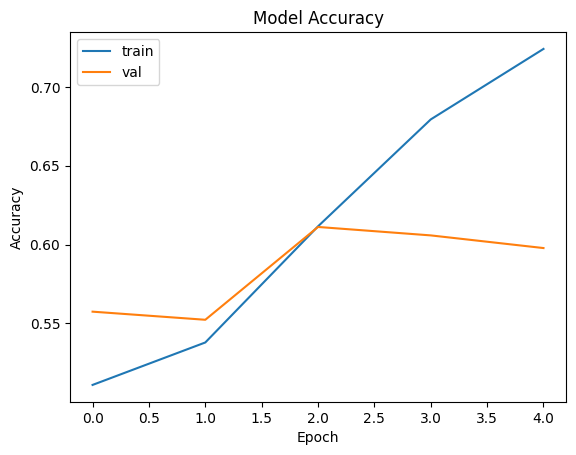

In [17]:
plt.plot(acc)
plt.plot(val_acc)

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

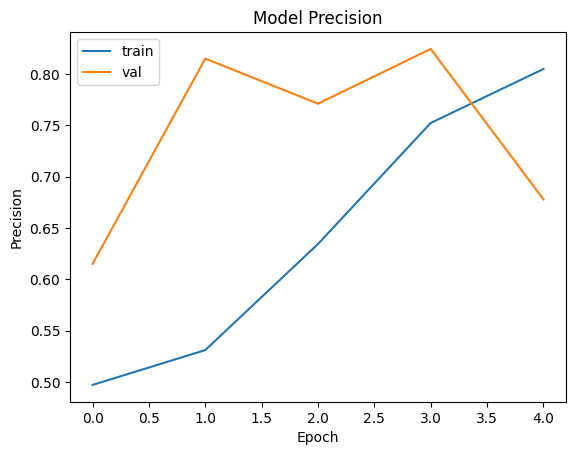

In [18]:
plt.plot(precision)
plt.plot(val_precision)

plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

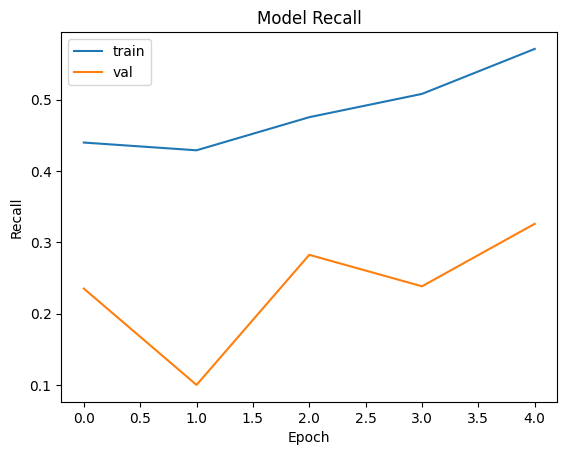

In [19]:
plt.plot(recall)
plt.plot(val_recall)

plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

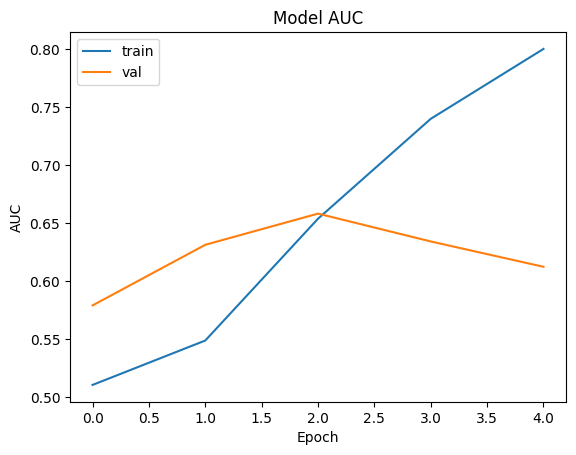

In [20]:
plt.plot(auc)
plt.plot(val_auc)

plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

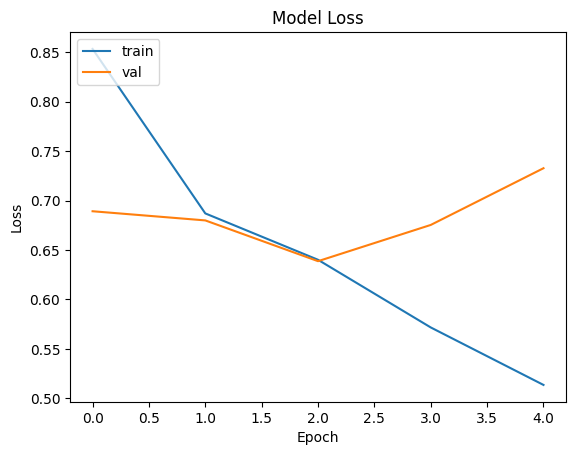

In [21]:
plt.plot(loss)
plt.plot(val_loss)

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Testing

In [183]:
loss, acc, prec, rec, auc, fp, fn, tp, tn = model.evaluate(test_dataset_cdfv2)

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f'Precision: {prec:.4f}')
print(f'Recall: {rec:.4f}')
print(f'AUC: {auc:.4f}')
print('--------------------')
print(f'False Positives: {fp}')
print(f'False Negatives: {fn}')
print(f'True Positives: {tp}')
print(f'True Negatives: {tn}')

2023-04-09 08:18:35.605181: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [16239]
	 [[{{node Placeholder/_0}}]]
2023-04-09 08:18:35.605724: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [16239]
	 [[{{node Placeholder/_0}}]]


508/508 [==============================] - 46s 90ms/step - loss: 0.6284 - binary_accuracy: 0.6754 - precision_14: 0.6160 - recall_14: 0.2276 - auc_14: 0.6363 - false_negatives_14: 4453.0000 - false_positives_14: 818.0000 - true_negatives_14: 9656.0000 - true_positives_14: 1312.0000
Loss: 0.6284
Accuracy: 0.6754
Precision: 0.6160
Recall: 0.2276
AUC: 0.6363
--------------------
False Positives: 4453.0
False Negatives: 818.0
True Positives: 9656.0
True Negatives: 1312.0


## Obtaining Test video scores

### Functions

In [39]:
from sklearn import metrics

In [40]:
class VideoScore():
    def __init__(self, filename, score, true_class, fake_on_lower_half = True):
        self.filename = filename
        self.score = score
        self.true_class = true_class
        self.fake_on_lower_half = fake_on_lower_half

    def get_filename(self):
        return self.filename
    
    def get_score(self):
        return self.score
    
    def get_true_class(self):
        return self.true_class
    
    def get_fake_on_lower_half(self):
        return self.fake_on_lower_half

In [41]:
def calculate_metrics(scores):
    true_fake, true_real, false_fake, false_real = 0, 0, 0, 0

    for vid_score in scores:
        score = vid_score.get_score()
        if score < 0.5 and vid_score.get_true_class() == CLASS_FAKE:
            true_fake += 1

        elif score >= 0.5 and vid_score.get_true_class() == CLASS_REAL:
            true_real += 1

        elif score < 0.5 and vid_score.get_true_class() == CLASS_REAL:
            false_fake += 1

        else:
            false_real += 1

    accuracy = (true_real + true_fake) / (true_fake + true_real + false_fake + false_real)
    precision = true_fake / (true_fake + false_fake)
    recall = true_fake / (true_fake + false_real)


    y_true = [0 if x.get_true_class() == CLASS_FAKE else 1 for x in scores]
    y_score = [0 if x.get_score() < 0.5 else 1 for x in scores]

    auc = metrics.roc_auc_score(y_true, y_score)

    all_metrics = {}
    all_metrics['true_fake'] = true_fake    
    all_metrics['true_real'] = true_real
    all_metrics['false_fake'] = false_fake
    all_metrics['false_real'] = false_real
    all_metrics['accuracy'] = accuracy
    all_metrics['precision'] = precision
    all_metrics['recall'] = recall
    all_metrics['AUC'] = auc

    return all_metrics

In [42]:
def get_residuals(fp, num_segments):
    vid_container = av.open(fp)
    vid_stream = vid_container.streams.video[0]
    frame_count = vid_stream.frames

    segment_dividers = get_segment_dividers(frame_count, num_segments)

    vid_container.seek(0)
    frame_list = [frame.to_image() for frame in vid_container.decode()]

    residuals = []
    start_index = 0
    for sd in segment_dividers:
        residuals.append(frame_list[start_index:sd])
        start_index = sd
    
    residuals.append(frame_list[start_index:])

    return residuals

In [43]:
def calculate_video_scores(model, fp):
    residuals = get_residuals(fp, num_segments=3)

    results = []
    for residual_set in residuals:
        tf_frames = []

        for frame in residual_set:
            tf_frames.append(img_to_array(tf.image.resize(frame, size = [224, 224])))

        tf_frames = np.asarray(tf_frames)
        result = model.predict(tf_frames, verbose=0)
        results.append(np.average(result))

    max_val = np.max(results)
    min_val = np.min(results)

    return max_val if 1 - max_val < min_val else min_val

In [44]:
def calculate_scores(dataset, split, model):
    video_scores = []

    for class_dir in CLASS:
        print(f'Class started: {class_dir}')
    
        vid_dir = dataset + DS_FRAME_DIFF + split + class_dir
        for video in os.listdir(vid_dir):
            fp = vid_dir + video

            video_score = VideoScore(video, 
                                    calculate_video_scores(model, fp),
                                    class_dir)
            
            video_scores.append(video_score)

    return video_scores

In [ ]:
temporal_model_test_scores = calculate_scores(DS_CDFV2, DS_TEST, model)

with open(TEST_SCORE_PATH + 'temporal_scores_test_2', 'wb') as f:
    pickle.dump(temporal_model_test_scores, f)

In [257]:
temporal_model_test_scores = calculate_scores(DS_CDFV2, DS_TRAIN, model)

with open(TEST_SCORE_PATH + 'temporal_scores_train_2', 'wb') as f:
    pickle.dump(temporal_model_test_scores, f)

Class started: real/
Class started: fake/


### Test Results

In [46]:
with open(TEST_SCORE_PATH + 'temporal_scores_test', 'rb') as f:
    temporal_test_scores = pickle.load(f)

In [47]:
all_metrics = calculate_metrics(temporal_test_scores)

In [48]:
print(f'True Fake:{all_metrics["true_fake"]}')
print(f'True Real:{all_metrics["true_real"]}')
print(f'False Fake:{all_metrics["false_fake"]}')
print(f'False Real:{all_metrics["false_real"]}')
print(f'---')
print(f'Accuracy: {all_metrics["accuracy"]:.4f}')
print(f'Precision: {all_metrics["precision"]:.4f}')
print(f'Recall: {all_metrics["recall"]:.4f}')
print(f'AUC Score: {all_metrics["AUC"]:.4f}')

True Fake:314
True Real:42
False Fake:136
False Real:26
---
Accuracy: 0.6873
Precision: 0.6978
Recall: 0.9235
AUC Score: 0.5797
